## Temporal Fusion Transformer Test V2

Using device: cpu


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/1875478185.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price_ma5'] = df['price'].rolling(window=5).mean().fillna(method='bfill')
/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/1875478185.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price_ma20'] = df['price'].rolling(window=20).mean().fillna(method='bfill')
/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_94184/1875478185.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rsi'] = calculate_rsi(df['price'], 14).fillna(method='bfill')


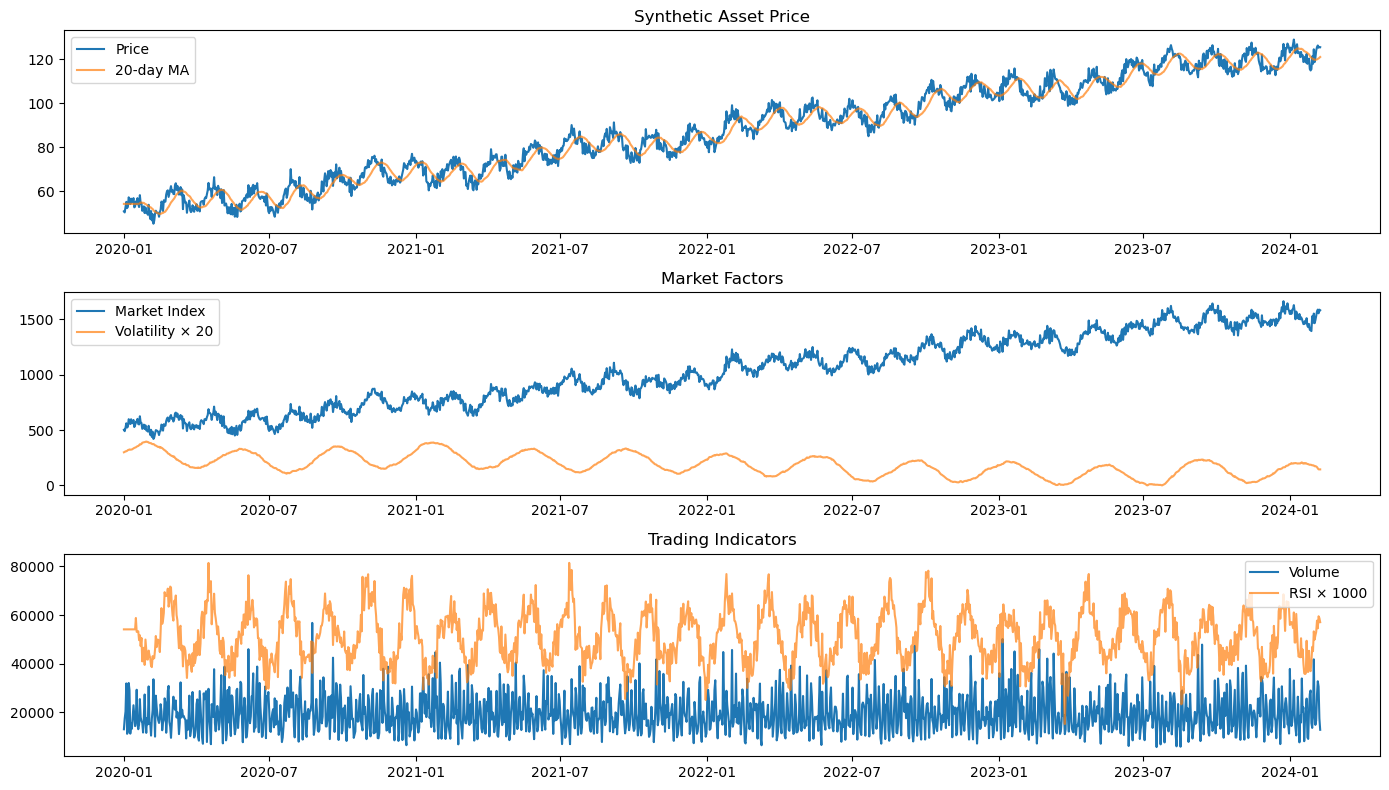

Training set size: 1172 sequences
Test set size: 294 sequences
Each sequence has 30 historical timesteps and predicts 5 future timesteps


TypeError: TemporalFusionTransformer.__init__() got an unexpected keyword argument 'num_static_vars'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from datetime import datetime, timedelta

# Import your TFT model
# Adjust the import path as needed
from models.tft_v2 import TemporalFusionTransformer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create synthetic financial data
def generate_financial_data(n_samples=1000, freq='D'):
    """Generate synthetic financial time series with trend, seasonality, and exogenous factors"""
    date_range = pd.date_range(start='2020-01-01', periods=n_samples, freq=freq)
    
    # Time index
    t = np.arange(n_samples)
    
    # Price components
    trend = 50 + 0.05 * t  # Upward trend
    seasonality = 5 * np.sin(2 * np.pi * t / 50) + 3 * np.sin(2 * np.pi * t / 250)  # Multiple seasonal patterns
    noise = np.random.normal(scale=2, size=n_samples)
    
    # Price
    price = trend + seasonality + noise
    
    # Generate exogenous variables
    # 1. Market index - correlated with price but with its own pattern
    market_index = 1000 + 0.03 * t + 30 * np.sin(2 * np.pi * t / 75) + np.random.normal(scale=10, size=n_samples)
    market_index = market_index * (1 + 0.3 * (price - np.mean(price)) / np.std(price))
    
    # 2. Trading volume - higher on volatile days
    volume = 10000 + 5000 * np.sin(2 * np.pi * t / 5) + 2000 * np.random.gamma(2, 1, size=n_samples)
    volume = volume * (1 + 0.5 * np.abs(noise) / np.std(noise))
    
    # 3. Volatility index
    volatility = 15 + 5 * np.sin(2 * np.pi * t / 120) + 3 * np.cumsum(np.random.normal(scale=0.05, size=n_samples))
    volatility = np.abs(volatility)
    
    # 4. Interest rate (slowly changing)
    interest_rate = 2 + 1 * np.sin(2 * np.pi * t / 500) + 0.5 * np.cumsum(np.random.normal(scale=0.01, size=n_samples))
    
    # 5. Day of week effect (categorical)
    weekday = np.array([d.weekday() for d in date_range])
    
    # 6. Month effect (categorical)
    month = np.array([d.month for d in date_range])
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': date_range,
        'price': price,
        'market_index': market_index,
        'volume': volume,
        'volatility': volatility,
        'interest_rate': interest_rate,
        'weekday': weekday,
        'month': month
    })
    
    # Add some technical indicators
    df['price_ma5'] = df['price'].rolling(window=5).mean().fillna(method='bfill')
    df['price_ma20'] = df['price'].rolling(window=20).mean().fillna(method='bfill')
    df['rsi'] = calculate_rsi(df['price'], 14).fillna(method='bfill')
    
    return df

# Calculate RSI (Relative Strength Index)
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=window).mean()
    loss = -delta.clip(upper=0).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Generate the dataset
df = generate_financial_data(n_samples=1500)

# Plot the generated data
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['price'], label='Price')
plt.plot(df['date'], df['price_ma20'], label='20-day MA', alpha=0.7)
plt.legend()
plt.title('Synthetic Asset Price')

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['market_index'], label='Market Index')
plt.plot(df['date'], df['volatility'] * 20, label='Volatility × 20', alpha=0.7)  # Scaled for visibility
plt.legend()
plt.title('Market Factors')

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['volume'], label='Volume')
plt.plot(df['date'], df['rsi'] * 1000, label='RSI × 1000', alpha=0.7)  # Scaled for visibility
plt.legend()
plt.title('Trading Indicators')

plt.tight_layout()
plt.show()

# Prepare data for TFT
# We'll use:
# - Static variables: None for this example
# - Past inputs: price history, technical indicators
# - Future inputs: known calendar features (weekday, month)

# Preprocess data
def preprocess_data(df):
    """Scale and prepare data for the TFT model"""
    
    # Create date features
    df['day_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Create scaled versions of numerical columns
    price_scaler = StandardScaler()
    market_scaler = StandardScaler()
    volume_scaler = StandardScaler()
    other_scaler = StandardScaler()
    
    # Price-related features
    price_cols = ['price', 'price_ma5', 'price_ma20']
    df[['price_scaled', 'price_ma5_scaled', 'price_ma20_scaled']] = price_scaler.fit_transform(df[price_cols])
    
    # Market features
    market_cols = ['market_index', 'volatility']
    df[['market_index_scaled', 'volatility_scaled']] = market_scaler.fit_transform(df[market_cols])
    
    # Volume
    df['volume_scaled'] = volume_scaler.fit_transform(df[['volume']])
    
    # Other features
    other_cols = ['interest_rate', 'rsi']
    df[['interest_rate_scaled', 'rsi_scaled']] = other_scaler.fit_transform(df[other_cols])
    
    return df, {
        'price': price_scaler,
        'market': market_scaler,
        'volume': volume_scaler,
        'other': other_scaler
    }

# Preprocess the data
df, scalers = preprocess_data(df)

# Define parameters
lookback_period = 30  # 30 days history
forecast_horizon = 5  # Predict 5 days ahead

# Create sequences
def create_sequences(df, lookback, horizon):
    """Create sequences for time series forecasting"""
    X_past_price = []  # Past price & indicators
    X_past_market = []  # Past market data
    X_future_calendar = []  # Future calendar features
    
    y = []  # Target prices
    
    for i in range(len(df) - lookback - horizon + 1):
        # Past data
        past_data = df.iloc[i:i+lookback]
        
        # Past price features
        past_price_features = past_data[['price_scaled', 'price_ma5_scaled', 'price_ma20_scaled', 'rsi_scaled']].values
        X_past_price.append(past_price_features)
        
        # Past market features
        past_market_features = past_data[['market_index_scaled', 'volatility_scaled', 'volume_scaled', 'interest_rate_scaled']].values
        X_past_market.append(past_market_features)
        
        # Future data - known calendar features
        future_data = df.iloc[i+lookback:i+lookback+horizon]
        future_calendar_features = future_data[['day_sin', 'day_cos', 'month_sin', 'month_cos']].values
        X_future_calendar.append(future_calendar_features)
        
        # Target - future prices
        target_prices = future_data['price_scaled'].values
        y.append(target_prices)
    
    return (
        torch.tensor(np.array(X_past_price), dtype=torch.float32),
        torch.tensor(np.array(X_past_market), dtype=torch.float32),
        torch.tensor(np.array(X_future_calendar), dtype=torch.float32),
        torch.tensor(np.array(y), dtype=torch.float32)
    )

# Create sequences
X_past_price, X_past_market, X_future_calendar, y = create_sequences(df, lookback_period, forecast_horizon)

# Train/test split (80/20)
train_size = int(0.8 * len(X_past_price))
test_size = len(X_past_price) - train_size

X_past_price_train, X_past_price_test = X_past_price[:train_size], X_past_price[train_size:]
X_past_market_train, X_past_market_test = X_past_market[:train_size], X_past_market[train_size:]
X_future_calendar_train, X_future_calendar_test = X_future_calendar[:train_size], X_future_calendar[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {train_size} sequences")
print(f"Test set size: {test_size} sequences")
print(f"Each sequence has {lookback_period} historical timesteps and predicts {forecast_horizon} future timesteps")

# Setup TFT model
encoder_input_sizes = [4, 4]  # Past price features, past market features
decoder_input_sizes = [4]     # Future calendar features
hidden_dim = 64
num_heads = 4
dropout = 0.1
num_lstm_layers = 2

model = TemporalFusionTransformer(
    num_static_vars=0,
    num_future_vars=1,
    num_past_vars=2,
    static_input_sizes=[],
    encoder_input_sizes=encoder_input_sizes,
    decoder_input_sizes=decoder_input_sizes,
    hidden_dim=hidden_dim,
    lstm_layers=num_lstm_layers,
    lstm_dropout=dropout,
    dropout=dropout,
    num_heads=num_heads,
    forecast_horizon=forecast_horizon,
    backcast_length=lookback_period,
    output_dim=1,
    quantiles=[0.1, 0.5, 0.9]
).to(device)

# Training function
def train_model(model, epochs=50, batch_size=32, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
    
    # Quantile loss function
    def quantile_loss(y_pred, y_true, quantiles):
        losses = []
        for i, q in enumerate([0.1, 0.5, 0.9]):
            errors = y_true - y_pred[:, :, :, i]
            losses.append(torch.max((q - 1) * errors, q * errors).mean())
        return torch.mean(torch.stack(losses))
    
    # For tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    
    # Progress trackers for plotting
    epoch_progress = []
    batch_progress = []
    batch_loss_values = []
    
    # Create mini-batches
    def get_batches(x_past_price, x_past_market, x_future_calendar, y_target, batch_size):
        for i in range(0, len(x_past_price), batch_size):
            yield (
                x_past_price[i:i+batch_size].to(device),
                x_past_market[i:i+batch_size].to(device),
                x_future_calendar[i:i+batch_size].to(device),
                y_target[i:i+batch_size].to(device)
            )
    
    model.train()
    total_batches = len(X_past_price_train) // batch_size + (1 if len(X_past_price_train) % batch_size != 0 else 0)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        # Shuffle training data
        indices = torch.randperm(len(X_past_price_train))
        X_past_price_train_shuffled = X_past_price_train[indices]
        X_past_market_train_shuffled = X_past_market_train[indices]
        X_future_calendar_train_shuffled = X_future_calendar_train[indices]
        y_train_shuffled = y_train[indices]
        
        # Training loop
        for batch_idx, (x_past_price_batch, x_past_market_batch, x_future_calendar_batch, y_batch) in enumerate(
            get_batches(X_past_price_train_shuffled, X_past_market_train_shuffled, 
                       X_future_calendar_train_shuffled, y_train_shuffled, batch_size)
        ):
            optimizer.zero_grad()
            
            # Prepare encoder/decoder inputs as lists
            encoder_inputs = [x_past_price_batch, x_past_market_batch]
            decoder_inputs = [x_future_calendar_batch]
            
            # Forward pass
            y_batch = y_batch.unsqueeze(-1)  # Add feature dimension to match model output
            predictions = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
            
            # Calculate loss
            loss = quantile_loss(predictions, y_batch, [0.1, 0.5, 0.9])
            
            # Backward and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Track progress
            epoch_loss += loss.item()
            batch_count += 1
            
            # For plotting
            epoch_progress.append(epoch + batch_idx/total_batches)
            batch_progress.append(epoch * total_batches + batch_idx)
            batch_loss_values.append(loss.item())
            
            # Print batch progress every few batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{total_batches}, Loss: {loss.item():.4f}")
        
        # Calculate validation loss
        model.eval()
        val_loss = 0.0
        val_batch_count = 0
        
        with torch.no_grad():
            for x_past_price_batch, x_past_market_batch, x_future_calendar_batch, y_batch in get_batches(
                X_past_price_test, X_past_market_test, X_future_calendar_test, y_test, batch_size
            ):
                # Prepare encoder/decoder inputs as lists
                encoder_inputs = [x_past_price_batch, x_past_market_batch]
                decoder_inputs = [x_future_calendar_batch]
                
                # Forward pass
                y_batch = y_batch.unsqueeze(-1)
                predictions = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
                
                # Calculate loss
                loss = quantile_loss(predictions, y_batch, [0.1, 0.5, 0.9])
                val_loss += loss.item()
                val_batch_count += 1
        
        avg_train_loss = epoch_loss / batch_count
        avg_val_loss = val_loss / val_batch_count
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Track best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_tft_model.pth')
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break
        
        # Switch back to training mode
        model.train()
    
    # Load best model
    model.load_state_dict(torch.load('best_tft_model.pth'))
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_epoch': best_epoch,
        'epoch_progress': epoch_progress,
        'batch_progress': batch_progress,
        'batch_loss_values': batch_loss_values
    }

# Train the model
history = train_model(model, epochs=50, batch_size=32, patience=10)

# Plot training curves
plt.figure(figsize=(15, 10))

# Training loss curve
plt.subplot(2, 1, 1)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.axvline(x=history['best_epoch'], color='r', linestyle='--', label=f'Best Model (Epoch {history["best_epoch"]+1})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TFT Training and Validation Loss')
plt.legend()
plt.grid(True)

# Batch loss curve
plt.subplot(2, 1, 2)
plt.plot(history['batch_progress'], history['batch_loss_values'], alpha=0.3, label='Batch Loss')
# Add a smoothed version
window_size = 20
if len(history['batch_loss_values']) > window_size:
    smoothed = np.convolve(history['batch_loss_values'], np.ones(window_size)/window_size, mode='valid')
    plt.plot(history['batch_progress'][window_size-1:], smoothed, label=f'Moving Avg (window={window_size})')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('TFT Training Loss by Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model
def evaluate_model(model, X_past_price, X_past_market, X_future_calendar, y_true, scalers):
    model.eval()
    predictions = []
    actual = []
    
    batch_size = 64
    
    with torch.no_grad():
        for i in range(0, len(X_past_price), batch_size):
            # Prepare batches
            x_past_price_batch = X_past_price[i:i+batch_size].to(device)
            x_past_market_batch = X_past_market[i:i+batch_size].to(device)
            x_future_calendar_batch = X_future_calendar[i:i+batch_size].to(device)
            y_batch = y_true[i:i+batch_size]
            
            # Prepare inputs as lists
            encoder_inputs = [x_past_price_batch, x_past_market_batch]
            decoder_inputs = [x_future_calendar_batch]
            
            # Forward pass - get all quantiles
            output = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
            
            # Extract median prediction (quantile 0.5 is index 1)
            median_preds = output[:, :, 0, 1].cpu()  # [batch, horizon, feature=0, quantile=0.5]
            
            # Store predictions and actual values
            predictions.append(median_preds)
            actual.append(y_batch)
    
    # Concatenate all batches
    predictions = torch.cat(predictions, dim=0).numpy()
    actual = torch.cat(actual, dim=0).numpy()
    
    # Inverse transform to get original scale
    predictions_orig = scalers['price'].inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
    actual_orig = scalers['price'].inverse_transform(actual.reshape(-1, 1)).reshape(actual.shape)
    
    return predictions, actual, predictions_orig, actual_orig

# Evaluate on train and test sets
train_preds, train_actual, train_preds_orig, train_actual_orig = evaluate_model(
    model, X_past_price_train, X_past_market_train, X_future_calendar_train, y_train, scalers
)

test_preds, test_actual, test_preds_orig, test_actual_orig = evaluate_model(
    model, X_past_price_test, X_past_market_test, X_future_calendar_test, y_test, scalers
)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    
    # Mean absolute percentage error
    mape = np.mean(np.abs((y_true.flatten() - y_pred.flatten()) / y_true.flatten())) * 100
    
    # Directional accuracy (for financial data)
    y_true_diff = np.diff(y_true, axis=1)
    y_pred_diff = np.diff(y_pred, axis=1)
    directional_acc = np.mean((y_true_diff * y_pred_diff) > 0) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Direction Accuracy': directional_acc
    }

# Calculate metrics for train and test sets
train_metrics = calculate_metrics(train_actual_orig, train_preds_orig)
test_metrics = calculate_metrics(test_actual_orig, test_preds_orig)

# Print metrics
print("\nTraining Set Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot forecasts
def plot_predictions(actual, predictions, split_idx, forecast_horizon=5, num_samples=100):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(15, 8))
    
    # Select a subset of data points for clarity
    indices = np.linspace(0, len(actual) - 1, num_samples, dtype=int)
    
    # Create x-axis with appropriate time indexing
    x = np.array(list(range(len(indices) * forecast_horizon)))
    
    # Initialize arrays for actual and predicted values
    y_true_plot = np.zeros(len(indices) * forecast_horizon)
    y_pred_plot = np.zeros(len(indices) * forecast_horizon)
    
    # Populate arrays
    for i, idx in enumerate(indices):
        for h in range(forecast_horizon):
            true_idx = i * forecast_horizon + h
            if true_idx < len(y_true_plot):
                y_true_plot[true_idx] = actual[idx, h]
                y_pred_plot[true_idx] = predictions[idx, h]
    
    # Split index for plot (convert from sequence index to plot index)
    plot_split_idx = (split_idx / len(actual)) * len(y_true_plot)
    
    # Plot
    plt.plot(x, y_true_plot, 'b-', label='True Price', alpha=0.7)
    plt.plot(x, y_pred_plot, 'r--', label='Predicted Price', alpha=0.7)
    
    # Draw vertical line for train/test split
    plt.axvline(x=plot_split_idx, color='green', linestyle='--', label='Train/Test Split')
    
    plt.title('Asset Price - True vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Combine train and test data for a continuous plot
all_actual = np.vstack([train_actual_orig, test_actual_orig])
all_preds = np.vstack([train_preds_orig, test_preds_orig])

# Plot predictions
plot_predictions(all_actual, all_preds, train_size, forecast_horizon=forecast_horizon)

# Visualize attention weights
def visualize_attention_weights(model, sample_idx=0):
    """Visualize attention weights for a sample input"""
    model.eval()
    
    with torch.no_grad():
        # Prepare inputs for a single sample
        x_past_price = X_past_price_test[sample_idx:sample_idx+1].to(device)
        x_past_market = X_past_market_test[sample_idx:sample_idx+1].to(device)
        x_future_calendar = X_future_calendar_test[sample_idx:sample_idx+1].to(device)
        
        # Prepare inputs as lists
        encoder_inputs = [x_past_price, x_past_market]
        decoder_inputs = [x_future_calendar]
        
        # Extract attention weights (hook the attention layer)
        attention_weights = None
        
        def hook_fn(module, input, output):
            nonlocal attention_weights
            # output is (output, attention_weights)
            attention_weights = output[1]
        
        # Register a forward hook on the attention layer
        hook = model.attention.register_forward_hook(hook_fn)
        
        # Forward pass
        _ = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
        
        # Remove the hook
        hook.remove()
        
        # Process attention weights
        if attention_weights is not None:
            # Average across attention heads
            avg_attn = attention_weights.mean(dim=1).squeeze(0).cpu().numpy()
            
            # Plot attention heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(
                avg_attn, 
                cmap='viridis',
                xticklabels=[f"t-{lookback_period-i}" for i in range(lookback_period)] + [f"t+{i+1}" for i in range(forecast_horizon)],
                yticklabels=[f"t-{lookback_period-i}" for i in range(lookback_period)] + [f"t+{i+1}" for i in range(forecast_horizon)]
            )
            plt.title('Self-Attention Weights Heatmap')
            plt.xlabel('Key Positions')
            plt.ylabel('Query Positions')
            plt.tight_layout()
            plt.show()

# Try to visualize attention weights if the model has the attention layer exposed
try:
    visualize_attention_weights(model)
except Exception as e:
    print(f"Could not visualize attention weights: {e}")
    print("Continuing with other visualizations...")

# # Visualize variable selection weights
# def visualize_variable_selection(model, num_samples=5):
#     """Visualize variable selection weights for a few samples"""
#     model.eval()
    
#     with torch.no_grad():
#         # Prepare inputs for a few samples
#         sample_indices = np.random.choice(len(X_past_price_test), size=num_samples, replace=False)
        
#         encoder_vsn_weights_samples = []
#         decoder_vsn_weights_samples = []
        
#         for idx in sample_indices:
#             # Prepare inputs
#             x_past_price = X_past_price_test[idx:idx+1].to(device)
#             x_past_market = X_past_market_test[idx:idx+1].to(device)
#             x_future_calendar = X_future_calendar_test[idx:idx+1].to(device)
            
#             # Prepare inputs as lists
#             encoder_inputs = [x_past_price, x_past_market]
#             decoder_inputs = [x_future_calendar]
            
#             # Extract VSN weights (we need to modify the model or use hooks)
#             encoder_vsn_weights = None
#             decoder_vsn_weights = None
            
#             def encoder_hook_fn(module, input, output):
#                 nonlocal encoder_vsn_weights
#                 # output is typically (combined, weights)
#                 encoder_vsn_weights = output[1]
            
#             def decoder_hook_fn(module, input, output):
#                 nonlocal decoder_vsn_weights
#                 decoder_vsn_weights = output[1]
            
#             # Register hooks on VSN modules
#             encoder_hook = model.encoder_vsn.register_forward_hook(encoder_hook_fn)
#             decoder_hook = model.decoder_vsn.register_forward_hook(decoder_hook_fn)
            
#             # Forward pass
#             _ = model(static_inputs=None, encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs)
            
#             # Remove hooks
#             encoder_hook.remove()
#             decoder_hook.remove()
            
#             # Collect weights
#             if encoder_vsn_weights is not None:
#                 encoder_vsn_weights_samples.append(encoder_vsn_weights.squeeze().cpu().numpy())
            
#             if decoder_vsn_weights is not None:
#                 decoder_vsn_weights_samples.append(decoder_vsn_weights.squeeze().cpu().numpy())
        
#         # Plot variable selection weights
#         if encoder_vsn_weights_samples and encoder_vsn_weights_samples[0].size > 0: